### Choose GPU settings, import libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(',')) 

import tensorflow as tf
from keras import backend as K
from keras.datasets import mnist

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True 
session = tf.compat.v1.Session(config=config)
K.set_session(session)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm import tqdm_notebook as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
from keras_helper import *
from skimage.transform import resize

ImportError: cannot import name 'multi_gpu_model' from 'keras.utils' (/home/adam/anaconda3/envs/tf212/lib/python3.9/site-packages/keras/utils/__init__.py)

### Some training parameters

In [4]:
h,w=64,64
nepochs=75
wt_path = 'wts4' #Where to store network weights
batch_size = 32

if (not os.path.isdir(wt_path)):
    os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [5]:
data_diffr = np.load('data/20191008_39_diff.npz')['arr_0']

In [6]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])


(161, 161, 256, 256)


/var/folders/sy/mr93m1ln7tq1hc3ghdqzwth40000gn/T/ipykernel_8903/3451499804.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_diffr.shape[0])):


  0%|          | 0/161 [00:00<?, ?it/s]

In [7]:
#amp = np.load('../expt_data/s26_data/20191008_30_10nm_amp.npz')['arr_0']
#ph = np.load('../expt_data/s26_data/20191008_39_10nm.npz')['arr_0']
real_space = np.load('data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

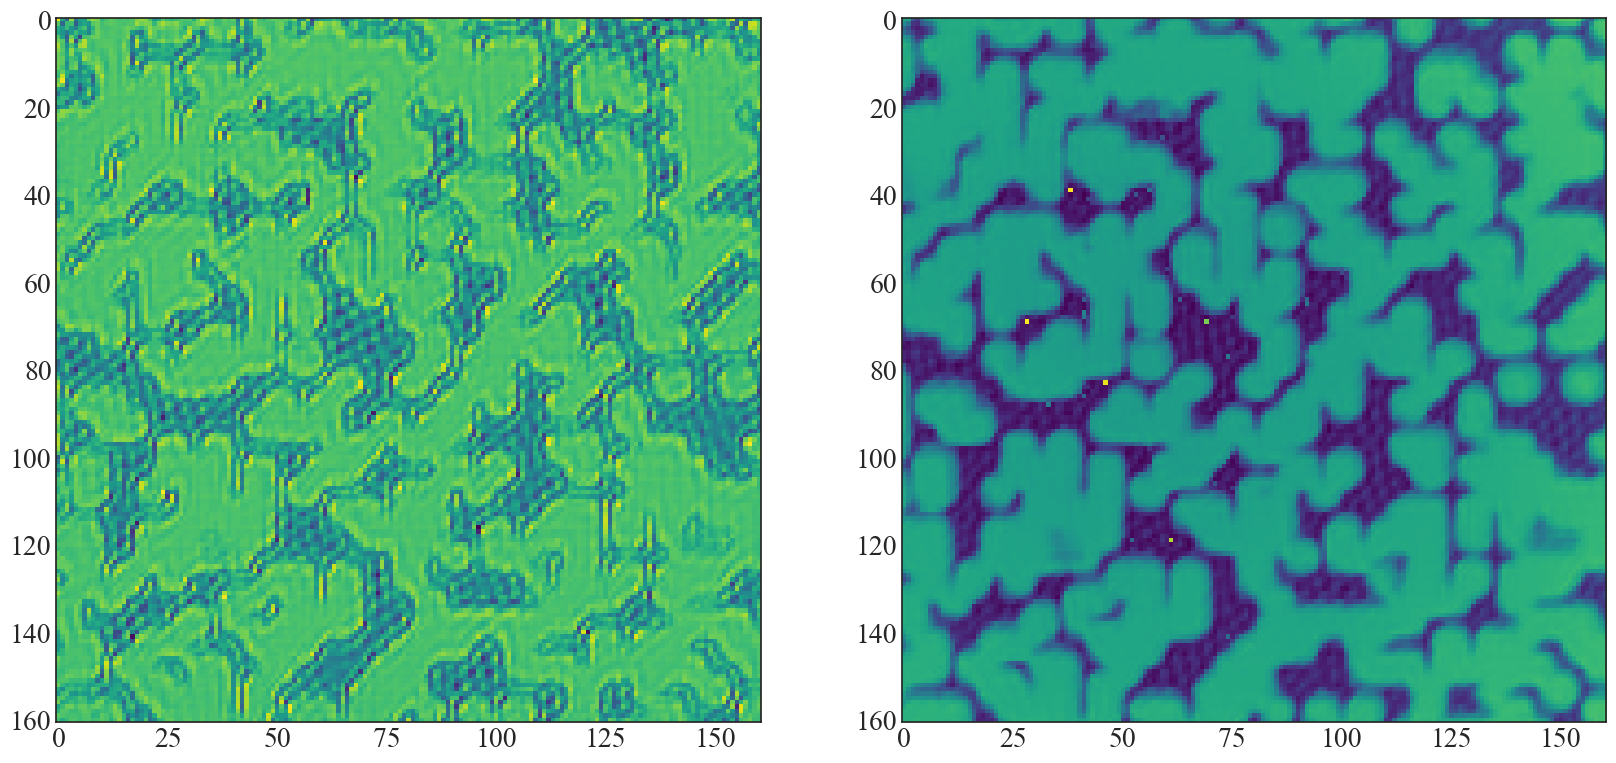

In [8]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [9]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

(16100, 64, 64, 1) (3600, 64, 64, 1)


### Save the test data for later use

In [11]:
np.save('data/X_test.npy', X_test) #Diffraction data
np.save('data/Y_I_test.npy', Y_I_test) #Intensity data
np.save('data/Y_phi_test.npy', Y_phi_test) #Intensity data

## Define the network structure

In [15]:
K.clear_session()
np.random.seed(123)
model=Sequential()

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)


input_img = Input(shape=(h, w, 1)) 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
#Activations are all ReLu

encoded=x

#Decoding arm 1
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)


#Decoding arm 2
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)

#Put together
autoencoder = Model(input_img, [decoded1, decoded2])
# parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

#print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')

In [16]:
print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [19]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)

checkpoints=keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.hdf5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', save_freq=batch_size)

history=autoencoder.fit(X_train, [Y_I_train, Y_phi_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=nepochs, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])

Epoch 1/75
478/478 [==============================] - 73s 152ms/step - loss: 0.0776 - conv2d_12_loss: 0.0037 - conv2d_19_loss: 0.0739 - val_loss: 0.1317 - val_conv2d_12_loss: 0.0046 - val_conv2d_19_loss: 0.1270 - lr: 1.0000e-04
Epoch 2/75
478/478 [==============================] - 69s 144ms/step - loss: 0.0773 - conv2d_12_loss: 0.0037 - conv2d_19_loss: 0.0737 - val_loss: 0.1315 - val_conv2d_12_loss: 0.0046 - val_conv2d_19_loss: 0.1269 - lr: 1.0000e-04
Epoch 3/75
478/478 [==============================] - 71s 149ms/step - loss: 0.0772 - conv2d_12_loss: 0.0037 - conv2d_19_loss: 0.0736 - val_loss: 0.1315 - val_conv2d_12_loss: 0.0046 - val_conv2d_19_loss: 0.1269 - lr: 1.0000e-04
Epoch 4/75
478/478 [==============================] - 73s 152ms/step - loss: 0.0770 - conv2d_12_loss: 0.0036 - conv2d_19_loss: 0.0734 - val_loss: 0.1317 - val_conv2d_12_loss: 0.0047 - val_conv2d_19_loss: 0.1270 - lr: 1.0000e-04
Epoch 5/75
478/478 [==============================] - 72s 151ms/step - loss: 0.0768 - co

In [24]:
print(hist.history.keys())

dict_keys(['loss', 'conv2d_12_loss', 'conv2d_19_loss', 'val_loss', 'val_conv2d_12_loss', 'val_conv2d_19_loss', 'lr'])


## Plot metrics of the training

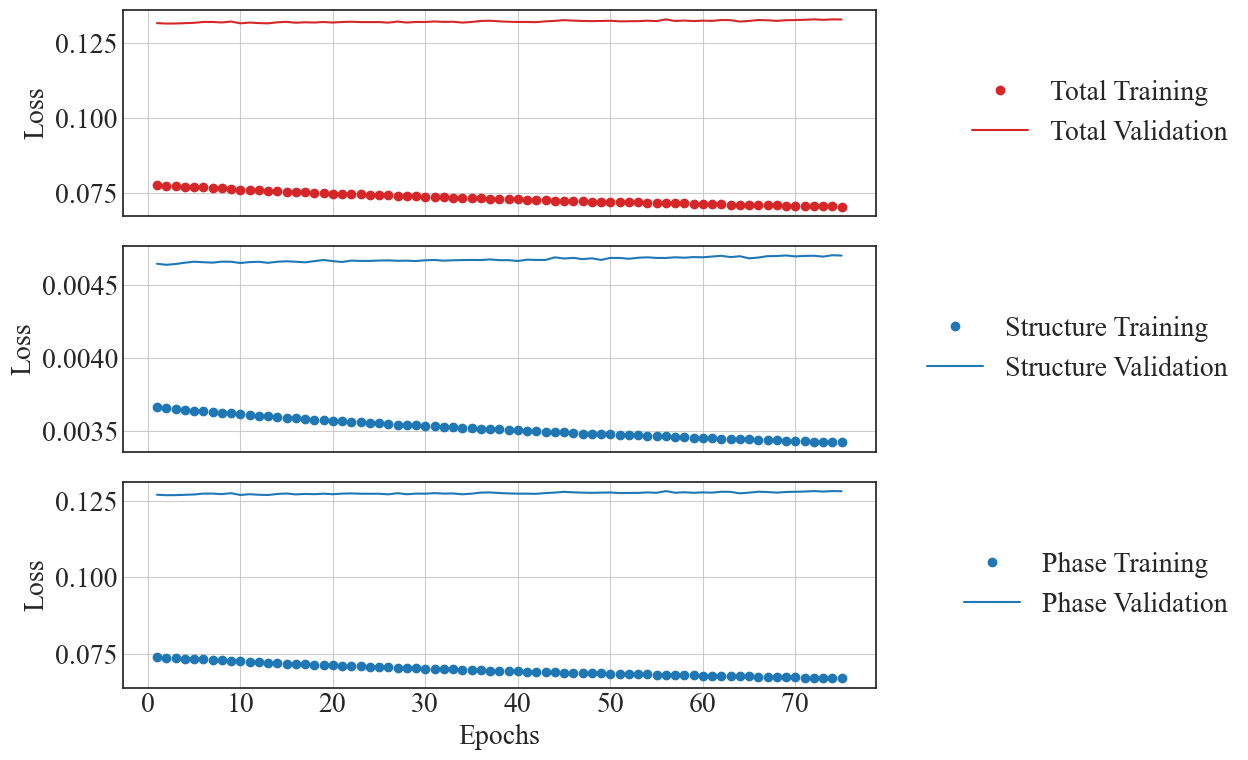

In [28]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-v0_8-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(3, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['conv2d_12_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_conv2d_12_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()


axarr[2].set(ylabel='Loss')
axarr[2].plot(epochs,hist.history['conv2d_19_loss'], 'C0o', label='Phase Training')
axarr[2].plot(epochs,hist.history['val_conv2d_19_loss'], 'C0-', label='Phase Validation')
axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
axarr[2].grid()


In [29]:
np.save('str_history', history.history)

In [31]:
print(history.history)

{'loss': [0.07757215201854706, 0.07734394073486328, 0.07722286134958267, 0.07701995223760605, 0.07683175802230835, 0.07670840620994568, 0.07654863595962524, 0.07641196250915527, 0.07621588557958603, 0.07602216303348541, 0.07589944452047348, 0.07577421516180038, 0.07565302401781082, 0.07550785690546036, 0.0753292515873909, 0.0752040445804596, 0.07505129277706146, 0.0749497339129448, 0.0748608261346817, 0.07468032836914062, 0.07465596497058868, 0.0745047852396965, 0.07437751442193985, 0.07423026859760284, 0.0741611123085022, 0.07408924400806427, 0.07387083768844604, 0.07378891110420227, 0.07371415197849274, 0.07361947745084763, 0.07353728264570236, 0.0734512060880661, 0.07332102954387665, 0.07323814928531647, 0.07312729209661484, 0.07303665578365326, 0.07292506843805313, 0.07290712743997574, 0.07285912334918976, 0.07271330803632736, 0.07256532460451126, 0.07256339490413666, 0.07248397171497345, 0.0723428875207901, 0.07229180634021759, 0.0722433552145958, 0.07210395485162735, 0.0720236822

### Save the epoch with the lowest validation loss
(PtychoNN will use these weights)

In [30]:
val_losses=hist.history['val_loss']
min_epoch=np.argmin(val_losses)+1
print (min_epoch)
np.save('%s/min_epoch' %(wt_path), min_epoch)

2
